In [ ]:
!pip install opencv-python-headless tqdm scikit-learn matplotlib seaborn

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torchvision import models, transforms
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Constants
VIDEO_PATH = "/content/drive/MyDrive/lsa64"
NUM_FRAMES = 12
IMAGE_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [ ]:
class LSA64Dataset(Dataset):
    def __init__(self, video_dir, transform=None):
        self.video_paths = sorted(glob(os.path.join(video_dir, "*.mp4")))
        self.transform = transform

        # Extract gloss labels (e.g., '001') and encode
        self.labels = [os.path.basename(v).split('_')[0] for v in self.video_paths]
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.encoded_labels[idx]
        frames = self.load_frames(path)

        if self.transform:
            frames = torch.stack([self.transform(f) for f in frames])
        return frames, label

    def load_frames(self, video_path):
      cap = cv2.VideoCapture(video_path)
      total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

      if total == 0:
          cap.release()
          print(f"⚠️ Skipping empty video: {video_path}")
          return [torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)] * NUM_FRAMES

      frame_idxs = np.linspace(0, total - 1, NUM_FRAMES, dtype=int)
      frames = []
      for i in range(total):
          ret, frame = cap.read()
          if i in frame_idxs and ret:
              frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              frames.append(frame)
      cap.release()

      if len(frames) == 0:
          print(f"⚠️ No readable frames in: {video_path}")
          return [torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)] * NUM_FRAMES

      if len(frames) < NUM_FRAMES:
          frames += [frames[-1]] * (NUM_FRAMES - len(frames))

      frames = [torch.from_numpy(f).permute(2, 0, 1).float() / 255.0 for f in frames]
      return frames



In [ ]:
dataset = LSA64Dataset(VIDEO_PATH, transform)
NUM_CLASSES = len(dataset.label_encoder.classes_)




In [ ]:
class ResNetLSTM(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=NUM_CLASSES):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(base.children())[:-1])
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        with torch.no_grad():
            cnn_out = self.cnn(x).view(B, T, -1)
        lstm_out, _ = self.lstm(cnn_out)
        return self.fc(lstm_out[:, -1, :])


In [ ]:
# Model
class ResNetLSTM(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=NUM_CLASSES):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(base.children())[:-1])
        for param in self.cnn.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        with torch.no_grad():
            cnn_out = self.cnn(x).view(B, T, -1)
        lstm_out, _ = self.lstm(cnn_out)
        return self.fc(lstm_out[:, -1, :])


In [ ]:
NUM_CLASSES = len(dataset.label_encoder.classes_)
print("NUM_CLASSES =", NUM_CLASSES)


NUM_CLASSES = 64


In [ ]:
dataset = LSA64Dataset(VIDEO_PATH, transform)
print("Total samples:", len(dataset))

# Train-test-val split
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=dataset.encoded_labels, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, stratify=[dataset.encoded_labels[i] for i in train_idx], random_state=42)

# DataLoaders
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE)

# Initialize model
model = ResNetLSTM(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Evaluation helper
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            all_preds.append(out.argmax(1).cpu())
            all_labels.append(y.cpu())
    return torch.cat(all_preds), torch.cat(all_labels)

Total samples: 3200


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


In [ ]:
train_accuracies = []
val_accuracies = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss, total_correct = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (out.argmax(1) == y).sum().item()

    train_acc = total_correct / len(train_idx)
    val_preds, val_labels = evaluate(val_loader)
    val_acc = (val_preds == val_labels).float().mean().item()

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Loss: {total_loss:.2f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if epoch in [8, 12, 16, 20, 24]:
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch}.pth")
        print(f"✅ Saved checkpoint at epoch {epoch}")


Epoch 1/24: 100%|██████████| 288/288 [26:15<00:00,  5.47s/it]


Loss: 1151.59 | Train Acc: 0.0525 | Val Acc: 0.1367


Epoch 2/24: 100%|██████████| 288/288 [25:23<00:00,  5.29s/it]


Loss: 1001.35 | Train Acc: 0.1493 | Val Acc: 0.2266


Epoch 3/24: 100%|██████████| 288/288 [25:19<00:00,  5.28s/it]


Loss: 861.84 | Train Acc: 0.3203 | Val Acc: 0.3398


Epoch 4/24: 100%|██████████| 288/288 [25:39<00:00,  5.35s/it]


Loss: 747.91 | Train Acc: 0.4288 | Val Acc: 0.5547


Epoch 5/24: 100%|██████████| 288/288 [25:14<00:00,  5.26s/it]


Loss: 640.57 | Train Acc: 0.5629 | Val Acc: 0.6172


Epoch 6/24: 100%|██████████| 288/288 [25:54<00:00,  5.40s/it]


Loss: 544.77 | Train Acc: 0.6454 | Val Acc: 0.7188


Epoch 7/24: 100%|██████████| 288/288 [24:48<00:00,  5.17s/it]


Loss: 460.50 | Train Acc: 0.7344 | Val Acc: 0.7461


Epoch 8/24: 100%|██████████| 288/288 [25:37<00:00,  5.34s/it]


Loss: 405.40 | Train Acc: 0.7799 | Val Acc: 0.7969
✅ Saved checkpoint at epoch 8


Epoch 9/24: 100%|██████████| 288/288 [25:25<00:00,  5.30s/it]


Loss: 337.76 | Train Acc: 0.8333 | Val Acc: 0.8359


Epoch 10/24: 100%|██████████| 288/288 [24:13<00:00,  5.05s/it]


Loss: 297.08 | Train Acc: 0.8507 | Val Acc: 0.8438


Epoch 11/24: 100%|██████████| 288/288 [25:21<00:00,  5.28s/it]


Loss: 247.62 | Train Acc: 0.8763 | Val Acc: 0.8398


Epoch 12/24: 100%|██████████| 288/288 [25:11<00:00,  5.25s/it]


Loss: 218.36 | Train Acc: 0.9010 | Val Acc: 0.8711
✅ Saved checkpoint at epoch 12


Epoch 13/24: 100%|██████████| 288/288 [25:26<00:00,  5.30s/it]


Loss: 190.24 | Train Acc: 0.9049 | Val Acc: 0.8789


Epoch 14/24: 100%|██████████| 288/288 [25:22<00:00,  5.29s/it]


Loss: 167.16 | Train Acc: 0.9223 | Val Acc: 0.9062


Epoch 15/24: 100%|██████████| 288/288 [25:09<00:00,  5.24s/it]


Loss: 145.20 | Train Acc: 0.9340 | Val Acc: 0.8906


Epoch 16/24: 100%|██████████| 288/288 [25:18<00:00,  5.27s/it]


Loss: 131.31 | Train Acc: 0.9366 | Val Acc: 0.9062
✅ Saved checkpoint at epoch 16


Epoch 17/24: 100%|██████████| 288/288 [25:28<00:00,  5.31s/it]


Loss: 115.18 | Train Acc: 0.9444 | Val Acc: 0.9180


Epoch 18/24: 100%|██████████| 288/288 [25:13<00:00,  5.25s/it]


Loss: 104.44 | Train Acc: 0.9557 | Val Acc: 0.9102


Epoch 19/24: 100%|██████████| 288/288 [25:27<00:00,  5.30s/it]


Loss: 90.28 | Train Acc: 0.9648 | Val Acc: 0.9375


Epoch 20/24: 100%|██████████| 288/288 [25:21<00:00,  5.28s/it]


Loss: 88.34 | Train Acc: 0.9627 | Val Acc: 0.9336
✅ Saved checkpoint at epoch 20


Epoch 21/24: 100%|██████████| 288/288 [25:15<00:00,  5.26s/it]


Loss: 76.02 | Train Acc: 0.9727 | Val Acc: 0.9453


Epoch 22/24: 100%|██████████| 288/288 [25:05<00:00,  5.23s/it]


Loss: 76.35 | Train Acc: 0.9670 | Val Acc: 0.9297


Epoch 23/24: 100%|██████████| 288/288 [25:53<00:00,  5.39s/it]


Loss: 67.18 | Train Acc: 0.9735 | Val Acc: 0.9453


Epoch 24/24: 100%|██████████| 288/288 [26:07<00:00,  5.44s/it]


Loss: 56.31 | Train Acc: 0.9796 | Val Acc: 0.9609
✅ Saved checkpoint at epoch 24


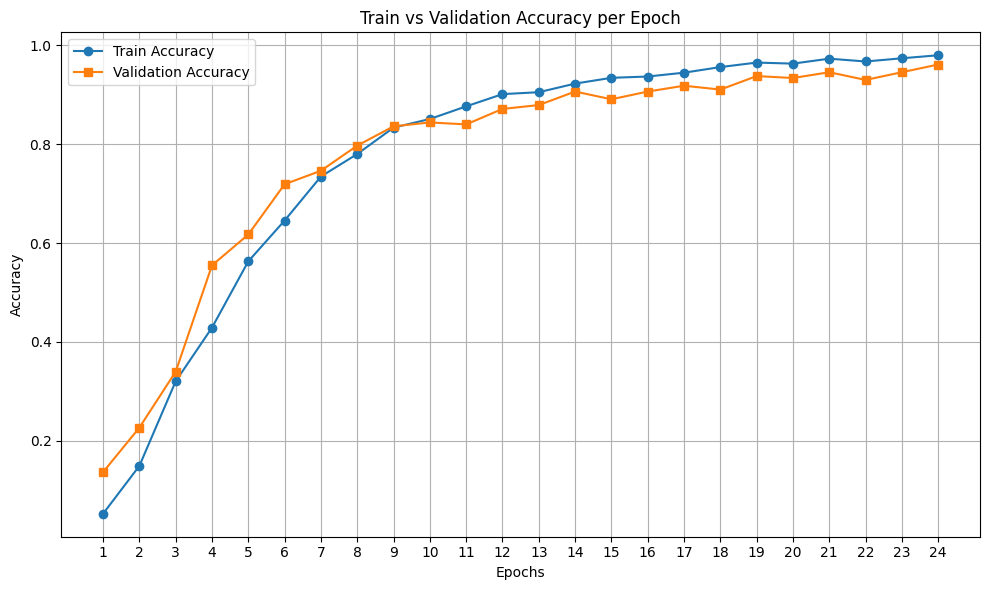

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 25))
train_acc = [
    0.0525, 0.1493, 0.3203, 0.4288, 0.5629, 0.6454, 0.7344, 0.7799,
    0.8333, 0.8507, 0.8763, 0.9010, 0.9049, 0.9223, 0.9340, 0.9366,
    0.9444, 0.9557, 0.9648, 0.9627, 0.9727, 0.9670, 0.9735, 0.9796
]
val_acc = [
    0.1367, 0.2266, 0.3398, 0.5547, 0.6172, 0.7188, 0.7461, 0.7969,
    0.8359, 0.8438, 0.8398, 0.8711, 0.8789, 0.9062, 0.8906, 0.9062,
    0.9180, 0.9102, 0.9375, 0.9336, 0.9453, 0.9297, 0.9453, 0.9609
]

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='s', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()
